# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from unidirectional_chamfer_distance import *
import scipy.io
import cv2
from skimage.transform import resize

# Visualization

### Load Camera Image, Lidar Point Clouds, and Radar Point Clouds

In [8]:
# choose a frame number to read and visualize. There are 10 frames provided as examples
frame_number = 10

# Load frame
## prepare folder paths
camera_frames_folder = 'Example Frames/camera images/'
lidar_frames_folder = 'Example Frames/lidar point clouds/'
radar_frames_folder = 'Example Frames/radar point clouds/'
radar_depth_maps = 'Example Frames/radar depth maps/'
result_depth_map = 'Example Frames/result depth map/'


## load frame
camera = plt.imread(camera_frames_folder+str(frame_number)+'.jpg')
lidar = np.load(lidar_frames_folder+str(frame_number)+'.npy')
radar = np.load(radar_frames_folder+str(frame_number)+'.npy')
radar_depth_map_SoTA = scipy.io.loadmat(radar_depth_maps+str(frame_number)+'.mat')['depth_map']
radar_depth_map_proposed = np.load(result_depth_map+str(frame_number)+'.npy')

### Visualize

(-95.7, 2031.7, 1209.3, 212.7)

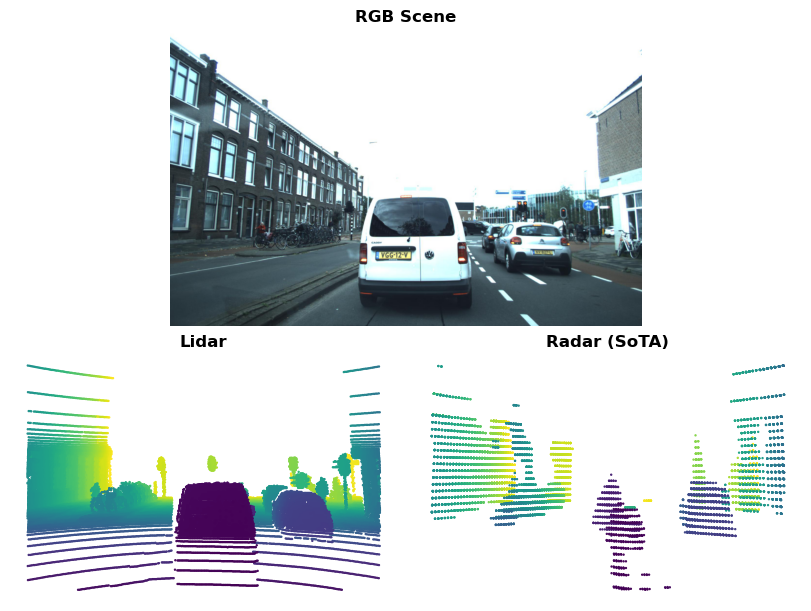

In [9]:
# Create a figure
fig = plt.figure(constrained_layout=True, figsize=(8, 6))

# Create a GridSpec with 2 rows and 2 columns
gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1])

# Create the first subplot: spans both columns in the first row
ax1 = fig.add_subplot(gs[0, :])
ax1.imshow(camera)
ax1.set_title('RGB Scene', fontweight='bold')
ax1.axis('off')

# Create the second subplot: first column in the second row
ax2 = fig.add_subplot(gs[1, 0])
plt.scatter(lidar[:,1], lidar[:,0], c=lidar[:,2], cmap='viridis', s=0.5)
plt.gca().invert_yaxis()
ax2.set_title('Lidar', fontweight='bold')
ax2.axis('off')


# Create the third subplot: second column in the second row
ax3 = fig.add_subplot(gs[1, 1])
plt.scatter(radar[:,1], radar[:,0], c=radar[:,2], cmap='viridis', s=0.5)
plt.gca().invert_yaxis()
ax3.set_title('Radar (SoTA)', fontweight='bold')
ax3.axis('off')

### Visualize SoTA vs. Proposed Depth Maps

(-0.5, 255.5, 255.5, -0.5)

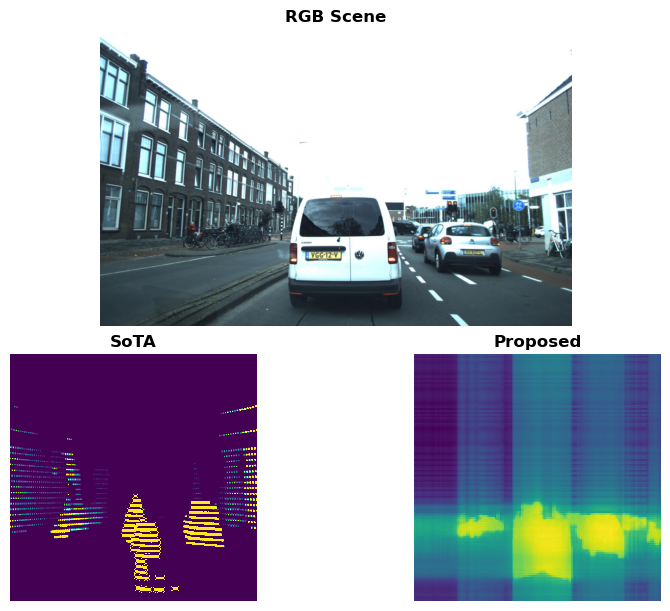

In [13]:
# Create a figure
fig = plt.figure(constrained_layout=True, figsize=(8, 6))

# Create a GridSpec with 2 rows and 2 columns
gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1])

# Create the first subplot: spans both columns in the first row
ax1 = fig.add_subplot(gs[0, :])
ax1.imshow(camera)
ax1.set_title('RGB Scene', fontweight='bold')
ax1.axis('off')

# Create the second subplot: first column in the second row
ax2 = fig.add_subplot(gs[1, 0])
plt.imshow(radar_depth_map_SoTA, vmax=10, vmin=0)
ax2.set_title('SoTA', fontweight='bold')
ax2.axis('off')

# Create the third subplot: second column in the second row
ax3 = fig.add_subplot(gs[1, 1])
plt.imshow(radar_depth_map_proposed)
ax3.set_title('Proposed', fontweight='bold')
ax3.axis('off')

# Calculate Unidirectional Chamfer Distance

### Define Preliminary Functions

In [5]:
def resize_frame(frame):
    image_size = (1216, 1936)
    depth_size = 300
    size_3D = (depth_size, image_size[0], image_size[1])
    my_3D_matrix = np.zeros(size_3D)

    my_coordinates = frame.copy() # point cloud coordinates
    my_coordinates[:,2] = my_coordinates[:,2]*10
    my_coordinates = my_coordinates.astype(int)

    my_3D_matrix[my_coordinates[:,2]-1, my_coordinates[:,0], my_coordinates[:,1]] = 1

    matrix_resampled = resize(my_3D_matrix, (300, 256, 256), mode='reflect', anti_aliasing=True)

    return matrix_resampled

def convert_to_3D(image, matrix_resampled):
    sample2 = image*matrix_resampled
    return sample2

def get_coordinats(matrix_resampled, sample2):
    # My output
    output_indices = np.nonzero(sample2)
    output_indices = np.column_stack(output_indices)

    # Original
    original_indices = np.nonzero(matrix_resampled)
    original_indices = np.column_stack(original_indices)

    return original_indices, output_indices

### Convert Depth Maps into 3D Point Clouds

In [6]:
my_input = radar # point cloud coordinates
resampled = resize_frame(my_input) # resize the original frame to be like the output of our model

# Ours
radar_depth_map_proposed = (1000**(radar_depth_map_proposed) > 200).astype(int)
my_output_ours = convert_to_3D(radar_depth_map_proposed, resampled) # output in 3D
input_indices_ours, output_indices_ours = get_coordinats(resampled, my_output_ours) # indecis of non zero locations

# SoTA
my_ones = np.ones((resampled.shape[1], resampled.shape[2])) # sample input image
my_output_sota = convert_to_3D(my_ones, resampled) # output in 3D
input_indices_sota, output_indices_sota = get_coordinats(resampled, my_output_sota) # indecis of non zero locations

# lidar (Ground Truth)
my_input = lidar # point cloud coordinates
resampled = resize_frame(my_input) # resize the original frame to be like the output of our model
my_ones = np.ones((resampled.shape[1], resampled.shape[2])) # sample input image
my_output = convert_to_3D(my_ones, resampled) # output in 3D
input_indices_gt, output_indices_gt = get_coordinats(resampled, my_output) # indecis of non zero locations



### Calculate Unidirectional Chamfer Distance

In [7]:
current_dist_sota = unidirectional_chamfer_distance(output_indices_sota, input_indices_gt)
current_dist_ours = unidirectional_chamfer_distance(output_indices_ours, input_indices_gt)

print('Ours: ', current_dist_ours)
print('SoTA: ', current_dist_sota)

Ours:  3.4139598018109796
SoTA:  4.965886466902187
